In [5]:
import pandas as pd 
import numpy as np 
from scipy.stats import chi2, shapiro

# Re-load the LDT Session 1 and LDT Session 2 data from the newly uploaded files
new_ldt_session_1_path = 'EZ_lexical_decision_part1_transformed.csv'
new_ldt_session_2_path = 'EZ_lexical_decision_part2_transformed.csv'

# Load the new data
new_ldt_session_1_data = pd.read_csv(new_ldt_session_1_path)
new_ldt_session_2_data = pd.read_csv(new_ldt_session_2_path)

# Check the first few rows to confirm data is loaded correctly
(new_ldt_session_1_data.head(), new_ldt_session_2_data.head())


(                   Experiment   v1_mean   v2_mean    a_mean  ndt_mean  \
 0  001_class_words_part_1.dat  1.735638 -1.647395  1.196706  0.361422   
 1  002_class_words_part_1.dat  1.646541 -2.039125  1.171614  0.513238   
 2  003_class_words_part_1.dat  2.671191 -2.926153  1.275182  0.435791   
 3  004_class_words_part_1.dat  2.367079 -2.302624  1.111747  0.384127   
 4  005_class_words_part_1.dat  2.961030 -3.611128  1.424967  0.406036   
 
    alpha_mean  accuracy_percentage  mean_log_rt  RT_mean_correct_error  \
 0    1.458020             0.899749     6.522493               0.701662   
 1    1.927072             0.914573     6.651658               0.809281   
 2    1.956327             0.977500     6.492267               0.680427   
 3    1.457351             0.930000     6.427847               0.631073   
 4    1.885865             0.985000     6.439964               0.642445   
 
    mean_correct  ...                                               q1_E  \
 0      0.703426  ...  [0.

In [6]:
new_ldt_session_1_data.insert(3, "v_total = v2_mean - v1_mean", new_ldt_session_1_data['v1_mean']-new_ldt_session_1_data['v2_mean'], True)
new_ldt_session_1_data.insert(4, "v_bias = v1_mean + v2_mean", new_ldt_session_1_data['v1_mean']+new_ldt_session_1_data['v2_mean'], True)
new_ldt_session_2_data.insert(3, "v_total = v2_mean - v1_mean", new_ldt_session_2_data['v1_mean']-new_ldt_session_2_data['v2_mean'], True)
new_ldt_session_2_data.insert(4, "v_bias = v1_mean + v2_mean", new_ldt_session_2_data['v1_mean']+new_ldt_session_2_data['v2_mean'], True)


In [7]:
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()



In [8]:
new_ldt_session_2_data['participant_ID']

0         1
1         2
2         3
3         4
4         5
       ... 
99     4009
100    4010
101    4011
102    4012
103    4013
Name: participant_ID, Length: 104, dtype: int64

In [9]:
# Re-identifying outliers for v1_mean using the updated data
# Extract the data for v1_mean
new_ldt_1_v1_mean = new_ldt_session_1_data.set_index('participant_ID')['v1_mean']
new_ldt_2_v1_mean = new_ldt_session_2_data.set_index('participant_ID')['v1_mean']

# Ensure only matching IDs are kept for comparison
new_common_ids = new_ldt_1_v1_mean.index.intersection(new_ldt_2_v1_mean.index)
new_paired_v1_means = pd.concat([new_ldt_1_v1_mean.loc[new_common_ids], new_ldt_2_v1_mean.loc[new_common_ids]], axis=1, keys=['Session1', 'Session2'])

# Calculate Mahalanobis distance using the safe function
new_mahalanobis_dist = safe_mahalanobis(x=new_paired_v1_means, data=new_paired_v1_means)

# Determine the threshold for p < 0.001
p_value = 0.001
new_threshold = chi2.ppf((1 - p_value), df=2)  # 2 variables, as we're looking at pairs

# Identify outliers
new_outliers = new_mahalanobis_dist > new_threshold

# Summarize the outliers
new_outlier_indices = new_paired_v1_means.index[new_outliers]
new_number_of_outliers = np.sum(new_outliers)

# Display the number of outliers and the threshold used
(new_number_of_outliers, new_outlier_indices, new_threshold)


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(1,
 Int64Index([1027], dtype='int64', name='participant_ID'),
 13.815510557964274)

In [10]:
def identify_outliers(columns, session_1_data, session_2_data, alpha=0.001):
    outlier_indices_dict = {}
    
    for col in columns:
        # Extract the data for the column
        session_1_col_data = session_1_data.set_index('participant_ID')[col]
        session_2_col_data = session_2_data.set_index('participant_ID')[col]

        # Ensure only matching IDs are kept for comparison
        common_ids = session_1_col_data.index.intersection(session_2_col_data.index)
        paired_col_data = pd.concat([session_1_col_data.loc[common_ids], session_2_col_data.loc[common_ids]], axis=1, keys=['Session1', 'Session2'])

        # Calculate Mahalanobis distance using the safe function
        mahalanobis_dist = safe_mahalanobis(x=paired_col_data, data=paired_col_data)

        # Determine the threshold for p < alpha
        threshold = chi2.ppf((1 - alpha), df=2)  # 2 variables, as we're looking at pairs

        # Identify outliers
        outliers = mahalanobis_dist > threshold
        outlier_indices = paired_col_data.index[outliers]
        
        # Save the indices of the outliers for each column
        outlier_indices_dict[col] = outlier_indices

    return outlier_indices_dict


columns_for_analysis = [
    'v1_mean',
    'v2_mean',
     'v_total = v2_mean - v1_mean',
    'v_bias = v1_mean + v2_mean',
    'a_mean',
    'ndt_mean',
    'alpha_mean',
    'accuracy_percentage',
    'mean_log_rt',
    'alpha_mean_boxcox_after_arcsin',
    'accuracy_percentage_boxcox_after_arcsin'
]

In [11]:
# Re-identify outliers for all specified columns using the updated data
new_outliers_dict = identify_outliers(columns_for_analysis, new_ldt_session_1_data, new_ldt_session_2_data)

# Display the number of outliers for each column
new_outlier_counts = {col: len(indices) for col, indices in new_outliers_dict.items()}
new_outlier_counts


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1,
 'v2_mean': 0,
 'v_total = v2_mean - v1_mean': 1,
 'v_bias = v1_mean + v2_mean': 0,
 'a_mean': 4,
 'ndt_mean': 1,
 'alpha_mean': 1,
 'accuracy_percentage': 1,
 'mean_log_rt': 1,
 'alpha_mean_boxcox_after_arcsin': 0,
 'accuracy_percentage_boxcox_after_arcsin': 0}

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import chi2

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Function to identify outliers for all specified columns
def identify_outliers(columns, session_1_data, session_2_data, alpha=0.001):
    outlier_indices_dict = {}
    
    for col in columns:
        # Extract the data for the column
        session_1_col_data = session_1_data.set_index('participant_ID')[col]
        session_2_col_data = session_2_data.set_index('participant_ID')[col]

        # Ensure only matching IDs are kept for comparison
        common_ids = session_1_col_data.index.intersection(session_2_col_data.index)
        paired_col_data = pd.concat([session_1_col_data.loc[common_ids], session_2_col_data.loc[common_ids]], axis=1)

        # Calculate Mahalanobis distance using the safe function
        mahalanobis_dist = safe_mahalanobis(x=paired_col_data, data=paired_col_data)

        # Determine the threshold for p < alpha
        threshold = chi2.ppf((1 - alpha), df=2)  # 2 variables, as we're looking at pairs

        # Identify outliers
        outliers = mahalanobis_dist > threshold
        outlier_indices = paired_col_data.index[outliers]
        
        # Save the indices of the outliers for each column
        outlier_indices_dict[col] = outlier_indices

    return outlier_indices_dict

# Load the data
# ldt_session_1_data = pd.read_csv('EZ_lexical_decision_part1_transformed.csv')
# ldt_session_2_data = pd.read_csv('EZ_lexical_decision_part2_transformed.csv')
ldt_session_1_data =new_ldt_session_1_data
ldt_session_2_data = new_ldt_session_2_data
# new_ldt_session_1_data.insert(3, "v_total = v2_mean - v1_mean", new_ldt_session_1_data['v1_mean']-new_ldt_session_1_data['v2_mean'], True)
# new_ldt_session_1_data.insert(4, "v_bias = v1_mean + v2_mean", new_ldt_session_1_data['v1_mean']+new_ldt_session_1_data['v2_mean'], True)
# new_ldt_session_2_data.insert(3, "v_total = v2_mean - v1_mean", new_ldt_session_2_data['v1_mean']-new_ldt_session_2_data['v2_mean'], True)
# new_ldt_session_2_data.insert(4, "v_bias = v1_mean + v2_mean", new_ldt_session_2_data['v1_mean']+new_ldt_session_2_data['v2_mean'], True)


# Columns specified for the reliability analysis
columns_for_analysis = [
    'v1_mean',
    'v2_mean',
     'v_total = v2_mean - v1_mean',
    'v_bias = v1_mean + v2_mean',
    'a_mean',
    'ndt_mean',
    'alpha_mean',
    'accuracy_percentage',
    'mean_log_rt',
    'alpha_mean_boxcox_after_arcsin',
    'accuracy_percentage_boxcox_after_arcsin'
]

# Identify outliers for each specified column between LDT Session 1 and LDT Session 2
outliers_dict = identify_outliers(columns_for_analysis, ldt_session_1_data, ldt_session_2_data)

# Display the number of outliers for each column
outlier_counts = {col: len(indices) for col, indices in outliers_dict.items()}
print(outlier_counts)


{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 0, 'a_mean': 4, 'ndt_mean': 1, 'alpha_mean': 1, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, pearsonr, shapiro

# Function to calculate Mahalanobis distance
# ... (same as previously defined)

# Function to identify outliers for all specified columns
# ... (same as previously defined)

# Function to remove outliers and calculate Pearson correlation
def analyze_and_plot(columns, session_1_data, session_2_data, alpha_outlier=0.001, alpha_normality=0.05):
    results = {}
    for col in columns:
        # Identify outliers
        outlier_indices = identify_outliers([col], session_1_data, session_2_data, alpha_outlier)[col]
        # Remove outliers
        clean_data = pd.concat([
            session_1_data.set_index('participant_ID')[col],
            session_2_data.set_index('participant_ID')[col]
        ], axis=1).drop(outlier_indices)
        
        # Calculate Pearson correlation
        correlation, p_value_corr = pearsonr(clean_data.iloc[:, 0], clean_data.iloc[:, 1])
        
        # Test for normality
        _, p_value_shapiro_1 = shapiro(clean_data.iloc[:, 0])
        _, p_value_shapiro_2 = shapiro(clean_data.iloc[:, 1])
        
        # Round the results to three decimals
        correlation = round(correlation, 3)
        p_value_corr = round(p_value_corr, 3)
        p_value_shapiro_1 = round(p_value_shapiro_1, 3)
        p_value_shapiro_2 = round(p_value_shapiro_2, 3)
        
        # Plotting
        plt.figure(figsize=(8, 6))
        plt.scatter(clean_data.iloc[:, 0], clean_data.iloc[:, 1], edgecolor='k')
        plt.title(f'Pearson Correlation for {col}\nCorrelation: {correlation} | p-value: {p_value_corr}')
        plt.xlabel('Session 1')
        plt.ylabel('Session 2')
        plt.grid(True)
        
        # Annotate with Shapiro-Wilk test results
        plt.annotate(f'Shapiro-Wilk Session 1: p={p_value_shapiro_1}', xy=(0.05, 0.92), xycoords='axes fraction')
        plt.annotate(f'Shapiro-Wilk Session 2: p={p_value_shapiro_2}', xy=(0.05, 0.88), xycoords='axes fraction')
        
        # Save the figure
        plt.savefig(f'correlation_plot_{col}.png', dpi=300, bbox_inches='tight')
        
        plt.close()
        
        # Store results
        results[col] = {
            'correlation': correlation,
            'p_value_corr': p_value_corr,
            'p_value_shapiro_1': p_value_shapiro_1,
            'p_value_shapiro_2': p_value_shapiro_2
        }
        
    return results

# Load the data
ldt_session_1_data = new_ldt_session_1_data
ldt_session_2_data = new_ldt_session_2_data

# Columns specified for the reliability analysis
# ... (same as previously defined)

# Run the analysis and plot for each column
results = analyze_and_plot(columns_for_analysis, ldt_session_1_data, ldt_session_2_data)
print(results)


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': {'correlation': 0.777, 'p_value_corr': 0.0, 'p_value_shapiro_1': 0.026, 'p_value_shapiro_2': 0.115}, 'v2_mean': {'correlation': 0.797, 'p_value_corr': 0.0, 'p_value_shapiro_1': 0.71, 'p_value_shapiro_2': 0.749}, 'v_total = v2_mean - v1_mean': {'correlation': 0.805, 'p_value_corr': 0.0, 'p_value_shapiro_1': 0.318, 'p_value_shapiro_2': 0.928}, 'v_bias = v1_mean + v2_mean': {'correlation': 0.717, 'p_value_corr': 0.0, 'p_value_shapiro_1': 0.621, 'p_value_shapiro_2': 0.628}, 'a_mean': {'correlation': 0.578, 'p_value_corr': 0.0, 'p_value_shapiro_1': 0.0, 'p_value_shapiro_2': 0.006}, 'ndt_mean': {'correlation': 0.511, 'p_value_corr': 0.0, 'p_value_shapiro_1': 0.036, 'p_value_shapiro_2': 0.0}, 'alpha_mean': {'correlation': 0.725, 'p_value_corr': 0.0, 'p_value_shapiro_1': 0.0, 'p_value_shapiro_2': 0.001}, 'accuracy_percentage': {'correlation': 0.885, 'p_value_corr': 0.0, 'p_value_shapiro_1': 0.0, 'p_value_shapiro_2': 0.0}, 'mean_log_rt': {'correlation': 0.758, 'p_value_corr': 0.0, '

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

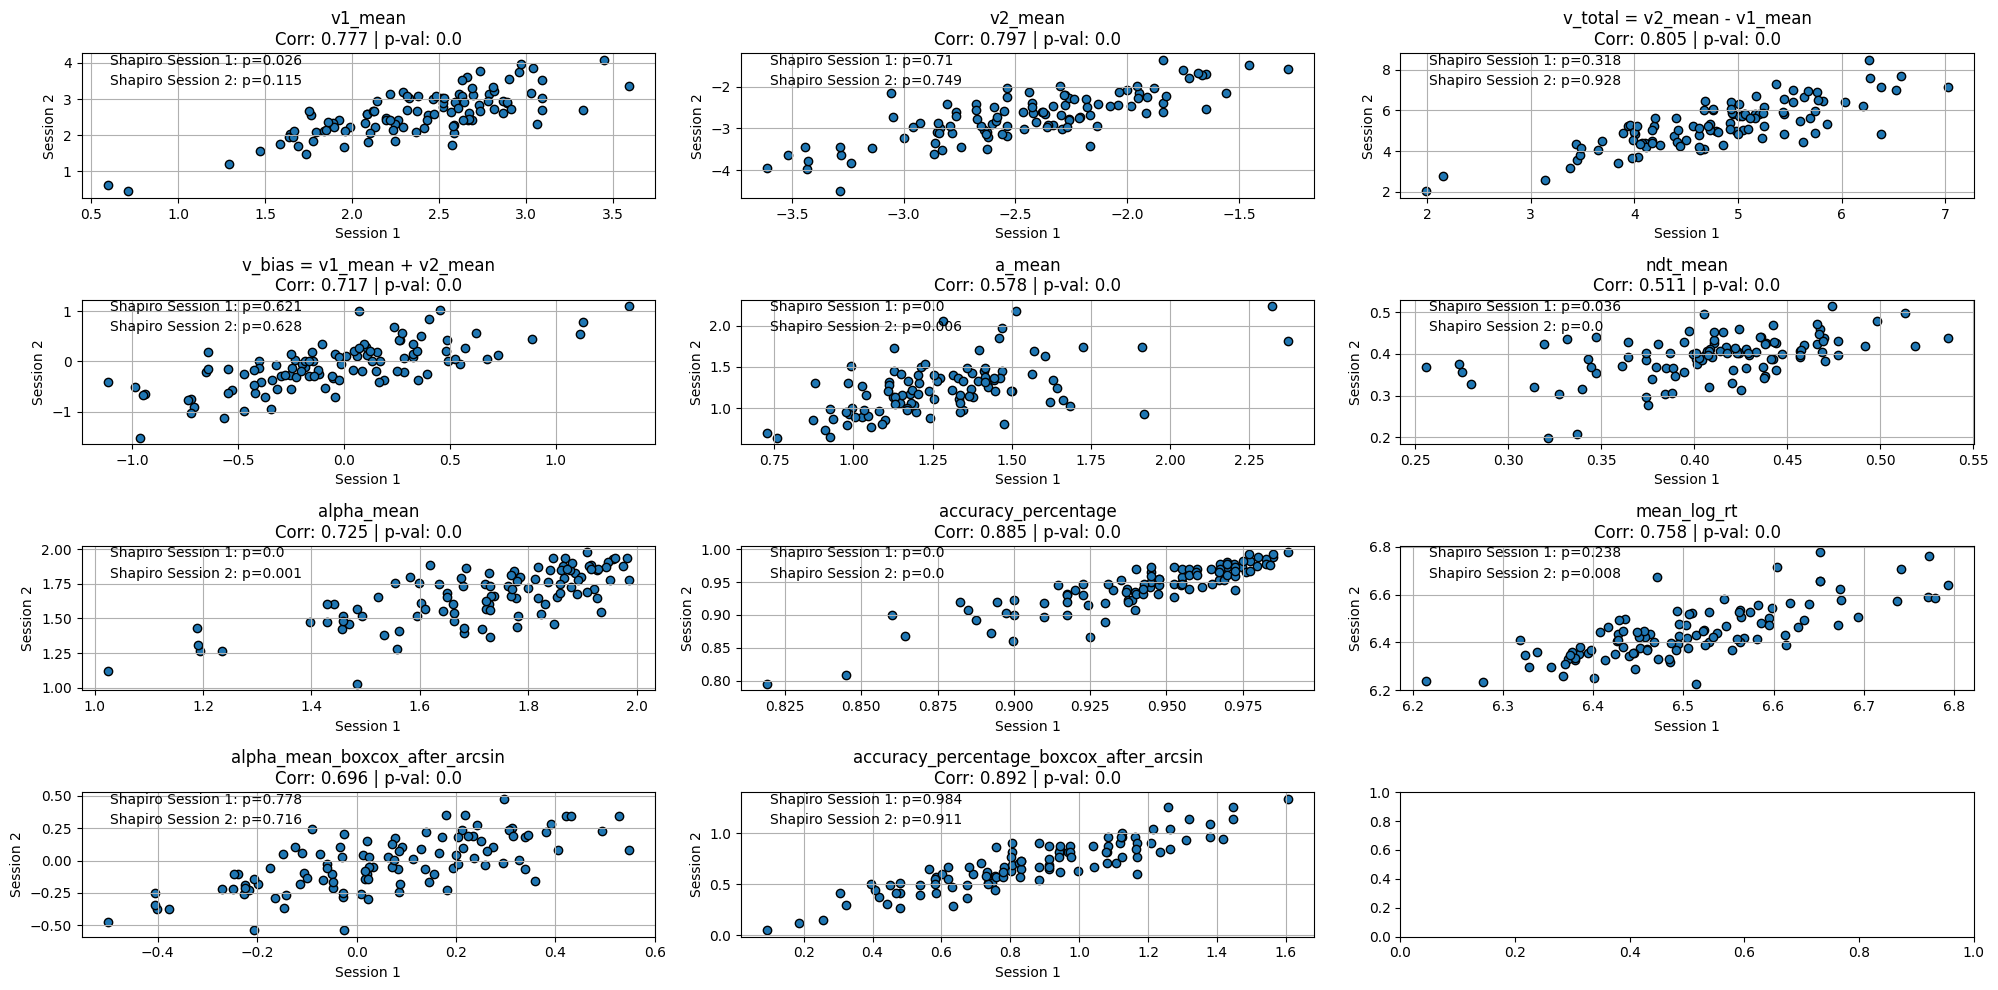

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, pearsonr, shapiro



# Prepare the figure for subplots
num_vars = len(columns_for_analysis)
num_rows = int(np.ceil(np.sqrt(num_vars)))
num_cols = int(np.ceil(num_vars / num_rows))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust the size as needed
axes = axes.flatten()

# Perform analysis for each variable and plot
for i, col in enumerate(columns_for_analysis):
    # Identify and remove outliers
    outlier_indices = identify_outliers([col], ldt_session_1_data, ldt_session_2_data)[col]
    clean_data = pd.concat([
        ldt_session_1_data.set_index('participant_ID')[col],
        ldt_session_2_data.set_index('participant_ID')[col]
    ], axis=1).drop(outlier_indices)
    
    # Calculate Pearson correlation
    correlation, p_value_corr = pearsonr(clean_data.iloc[:, 0], clean_data.iloc[:, 1])
    
    # Test for normality
    _, p_value_shapiro_1 = shapiro(clean_data.iloc[:, 0])
    _, p_value_shapiro_2 = shapiro(clean_data.iloc[:, 1])
    
    # Round the results to three decimals
    correlation = round(correlation, 3)
    p_value_corr = round(p_value_corr, 3)
    p_value_shapiro_1 = round(p_value_shapiro_1, 3)
    p_value_shapiro_2 = round(p_value_shapiro_2, 3)
    
    # Plotting on the subplot
    ax = axes[i]
    ax.scatter(clean_data.iloc[:, 0], clean_data.iloc[:, 1], edgecolor='k')
    ax.set_title(f'{col}\nCorr: {correlation} | p-val: {p_value_corr}')
    ax.set_xlabel('Session 1')
    ax.set_ylabel('Session 2')
    ax.grid(True)
    
    # Annotate with Shapiro-Wilk test results
    ax.annotate(f'Shapiro Session 1: p={p_value_shapiro_1}', xy=(0.05, 0.92), xycoords='axes fraction')
    ax.annotate(f'Shapiro Session 2: p={p_value_shapiro_2}', xy=(0.05, 0.78), xycoords='axes fraction')

# Adjust layout for readability
plt.tight_layout()

# Save the figure
plt.savefig('EZ_combined_correlation_plots.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

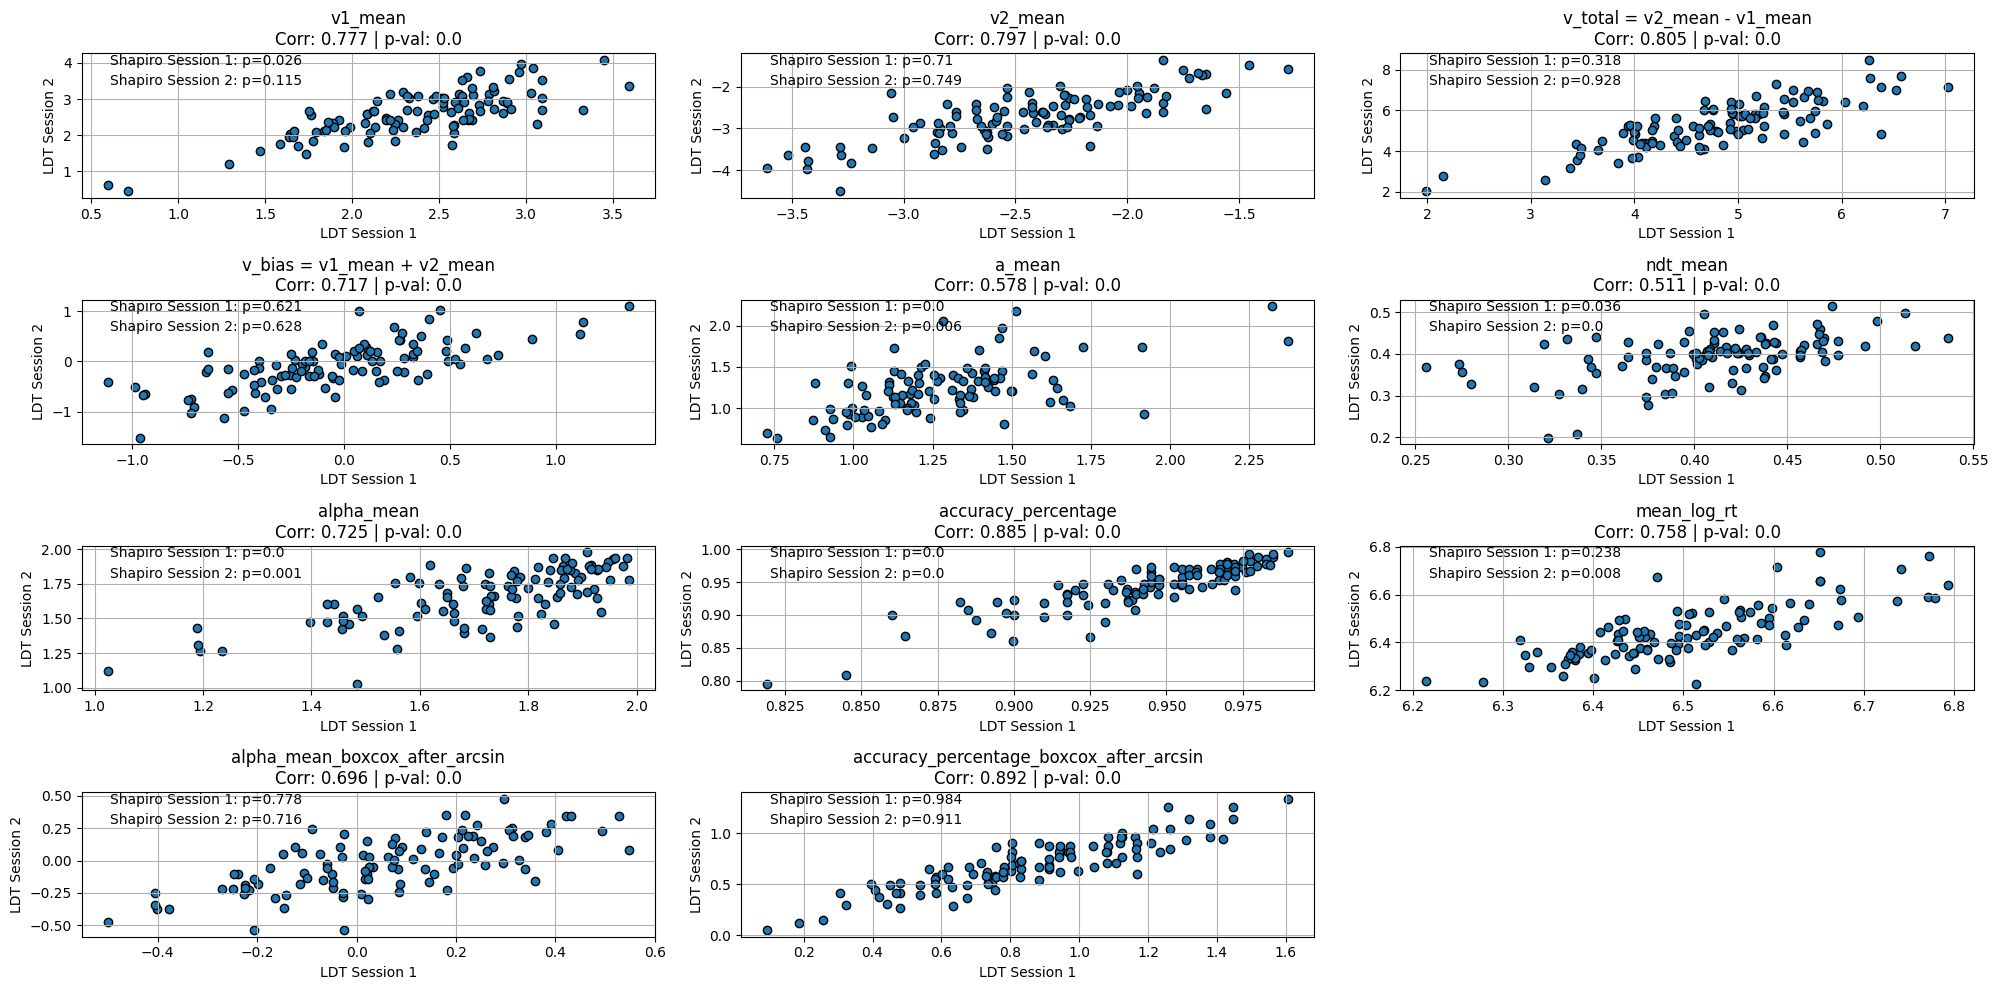

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, pearsonr, shapiro



# Prepare the figure for subplots
num_vars = len(columns_for_analysis)
num_rows = int(np.ceil(np.sqrt(num_vars)))
num_cols = int(np.ceil(num_vars / num_rows))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust the size as needed
axes = axes.flatten()


#############################################################
LDT_Bet_session_correlation_matrix = pd.DataFrame()

# Perform analysis for each variable and plot
for i, col in enumerate(columns_for_analysis):
    # Identify and remove outliers
    outlier_indices = identify_outliers([col], ldt_session_1_data, ldt_session_2_data)[col]
    clean_data = pd.concat([
        ldt_session_1_data.set_index('participant_ID')[col],
        ldt_session_2_data.set_index('participant_ID')[col]
    ], axis=1).drop(outlier_indices)
    
    # Calculate Pearson correlation
    correlation, p_value_corr = pearsonr(clean_data.iloc[:, 0], clean_data.iloc[:, 1])


    
    # Test for normality
    _, p_value_shapiro_1 = shapiro(clean_data.iloc[:, 0])
    _, p_value_shapiro_2 = shapiro(clean_data.iloc[:, 1])
    
    # Round the results to three decimals
    correlation = round(correlation, 3)
    LDT_Bet_session_correlation_matrix.loc[col,'LDT_Bet_session'] = correlation

    p_value_corr = round(p_value_corr, 3)
    p_value_shapiro_1 = round(p_value_shapiro_1, 3)
    p_value_shapiro_2 = round(p_value_shapiro_2, 3)
    
    # Plotting on the subplot
    ax = axes[i]
    ax.scatter(clean_data.iloc[:, 0], clean_data.iloc[:, 1], edgecolor='k')
    ax.set_title(f'{col}\nCorr: {correlation} | p-val: {p_value_corr}')
    ax.set_xlabel('LDT Session 1')
    ax.set_ylabel('LDT Session 2')
    ax.grid(True)
    
    # Annotate with Shapiro-Wilk test results
    ax.annotate(f'Shapiro Session 1: p={p_value_shapiro_1}', xy=(0.05, 0.92), xycoords='axes fraction')
    ax.annotate(f'Shapiro Session 2: p={p_value_shapiro_2}', xy=(0.05, 0.78), xycoords='axes fraction')

for ax in axes[len(columns_for_analysis):]:
    ax.set_visible(False)

# Adjust layout for readability
plt.tight_layout()

# Save the figure
plt.savefig('EZ_LDT_Between_session_combined_correlation_plots.png', dpi=300, bbox_inches='tight')

#Show the plot
#plt.show()


In [16]:
dict

dict

In [17]:
LDT_Bet_session_correlation_matrix

,LDT_Bet_session
v1_mean,0.777
v2_mean,0.797
v_total = v2_mean - v1_mean,0.805
v_bias = v1_mean + v2_mean,0.717
a_mean,0.578
ndt_mean,0.511
alpha_mean,0.725
accuracy_percentage,0.885
mean_log_rt,0.758
alpha_mean_boxcox_after_arcsin,0.696


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

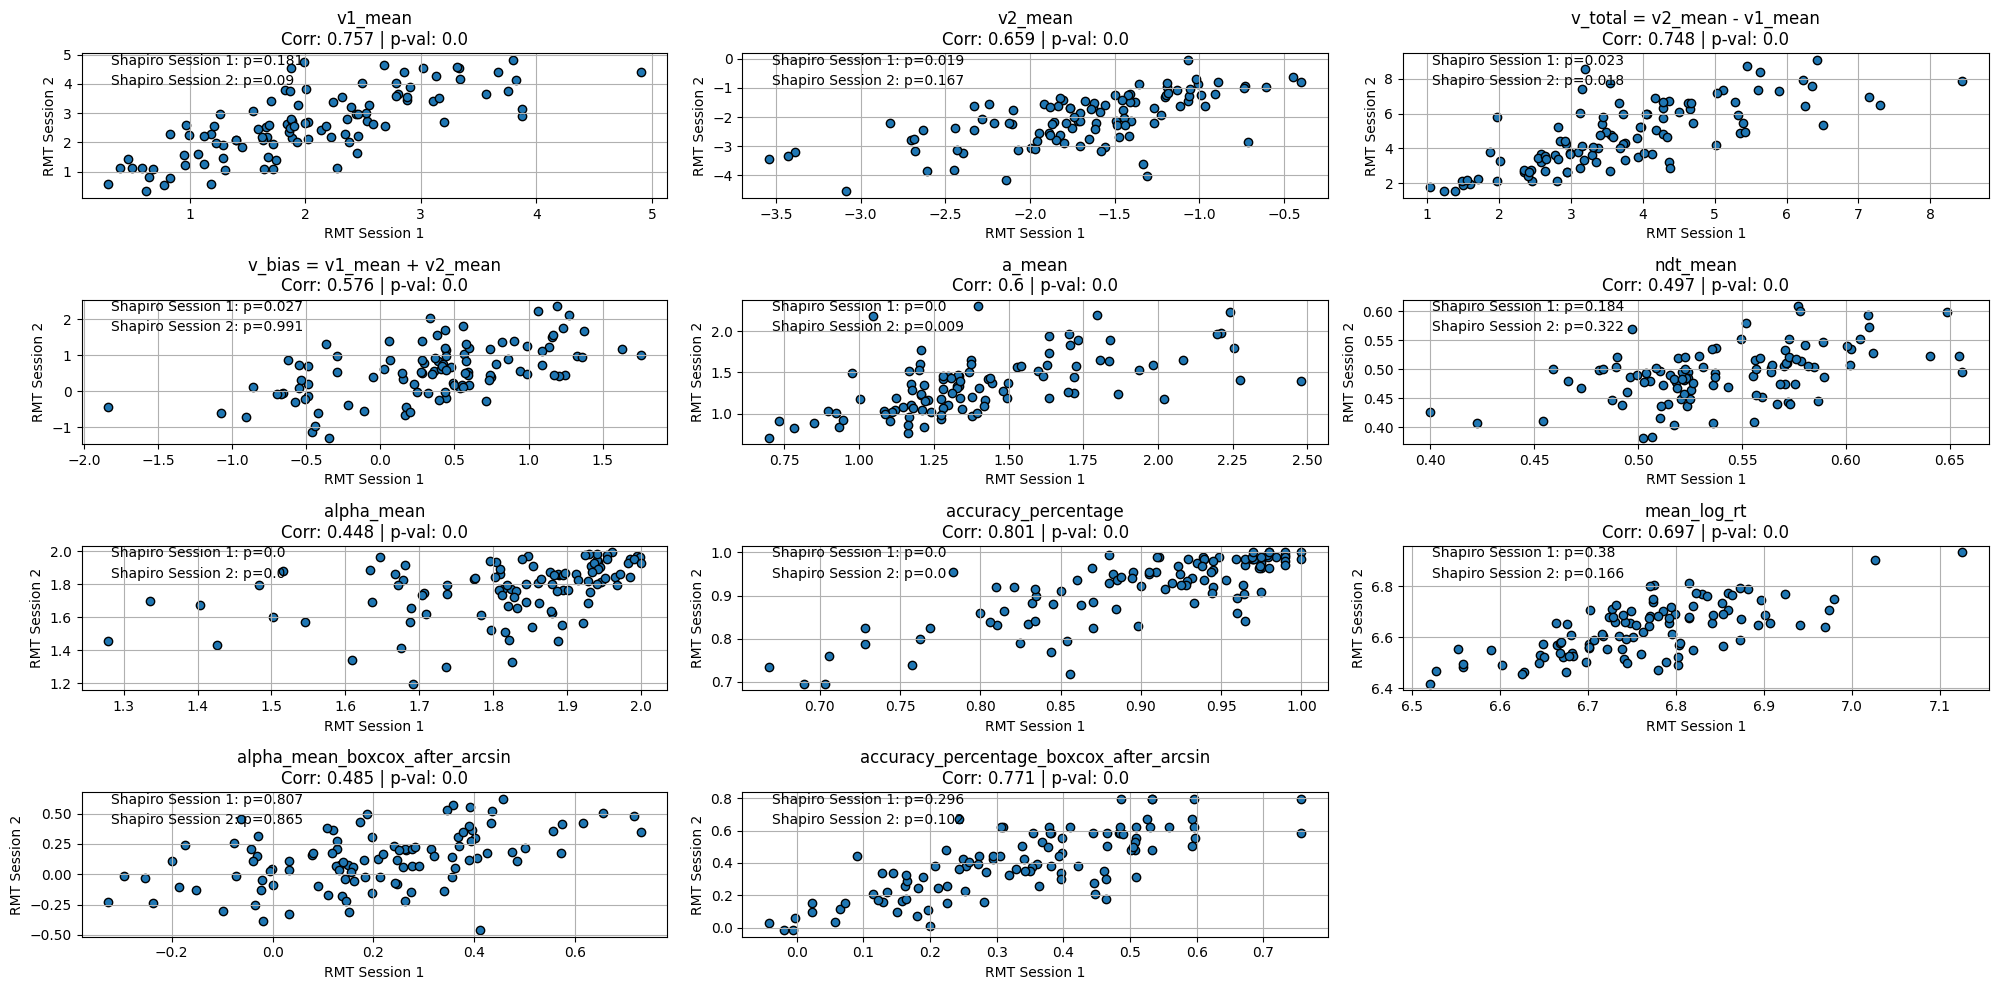

In [20]:
# Load the RMT Session 1 and Session 2 data
rmt_session_1_data = pd.read_csv('EZ_recognition_memory_part1_transformed.csv')
rmt_session_2_data = pd.read_csv('EZ_recognition_memory_part2_transformed.csv')

rmt_session_1_data.insert(3, "v_total = v2_mean - v1_mean", rmt_session_1_data['v1_mean']-rmt_session_1_data['v2_mean'], True)
rmt_session_1_data.insert(4, "v_bias = v1_mean + v2_mean", rmt_session_1_data['v1_mean']+rmt_session_1_data['v2_mean'], True)

rmt_session_2_data.insert(3, "v_total = v2_mean - v1_mean", rmt_session_2_data['v1_mean']-rmt_session_2_data['v2_mean'], True)
rmt_session_2_data.insert(4, "v_bias = v1_mean + v2_mean", rmt_session_2_data['v1_mean']+rmt_session_2_data['v2_mean'], True)



# Prepare the figure for subplots
num_vars = len(columns_for_analysis)
num_rows = int(np.ceil(np.sqrt(num_vars)))
num_cols = int(np.ceil(num_vars / num_rows))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust the size as needed
axes = axes.flatten()



RMT_Bet_session_correlation_matrix = pd.DataFrame()

# Perform analysis for each variable and plot
for i, col in enumerate(columns_for_analysis):
    # Identify and remove outliers
    outlier_indices = identify_outliers([col], rmt_session_1_data, rmt_session_2_data)[col]
    clean_data = pd.concat([
        rmt_session_1_data.set_index('participant_ID')[col],
        rmt_session_2_data.set_index('participant_ID')[col]
    ], axis=1).drop(outlier_indices)
    
    # Calculate Pearson correlation
    correlation, p_value_corr = pearsonr(clean_data.iloc[:, 0], clean_data.iloc[:, 1])
    
    # Test for normality
    _, p_value_shapiro_1 = shapiro(clean_data.iloc[:, 0])
    _, p_value_shapiro_2 = shapiro(clean_data.iloc[:, 1])
    
    # Round the results to three decimals
    correlation = round(correlation, 3)
    RMT_Bet_session_correlation_matrix.loc[col,'RMT_Bet_session']=correlation
    p_value_corr = round(p_value_corr, 3)
    p_value_shapiro_1 = round(p_value_shapiro_1, 3)
    p_value_shapiro_2 = round(p_value_shapiro_2, 3)
    
    # Plotting on the subplot
    ax = axes[i]
    ax.scatter(clean_data.iloc[:, 0], clean_data.iloc[:, 1], edgecolor='k')
    ax.set_title(f'{col}\nCorr: {correlation} | p-val: {p_value_corr}')
    ax.set_xlabel('RMT Session 1')
    ax.set_ylabel('RMT Session 2')
    ax.grid(True)
    
    # Annotate with Shapiro-Wilk test results
    ax.annotate(f'Shapiro Session 1: p={p_value_shapiro_1}', xy=(0.05, 0.92), xycoords='axes fraction')
    ax.annotate(f'Shapiro Session 2: p={p_value_shapiro_2}', xy=(0.05, 0.78), xycoords='axes fraction')

# Hide any unused subplots
for ax in axes[len(columns_for_analysis):]:
    ax.set_visible(False)

# Adjust layout for readability and save the figure
plt.tight_layout()
plt.savefig('EZ_RMT_Between_session_combined_correlation_plots.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [22]:
new_outliers_dict = identify_outliers(columns_for_analysis, rmt_session_1_data, rmt_session_2_data)

# Display the number of outliers for each column
new_outlier_counts = {col: len(indices) for col, indices in new_outliers_dict.items()}
new_outlier_counts


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 0,
 'v2_mean': 0,
 'v_total = v2_mean - v1_mean': 0,
 'v_bias = v1_mean + v2_mean': 0,
 'a_mean': 1,
 'ndt_mean': 2,
 'alpha_mean': 1,
 'accuracy_percentage': 0,
 'mean_log_rt': 0,
 'alpha_mean_boxcox_after_arcsin': 0,
 'accuracy_percentage_boxcox_after_arcsin': 0}

In [23]:
RMT_Bet_session_correlation_matrix

,RMT_Bet_session
v1_mean,0.757
v2_mean,0.659
v_total = v2_mean - v1_mean,0.748
v_bias = v1_mean + v2_mean,0.576
a_mean,0.600
ndt_mean,0.497
alpha_mean,0.448
accuracy_percentage,0.801
mean_log_rt,0.697
alpha_mean_boxcox_after_arcsin,0.485


# Makign Data Suitable for Across task correlation for session to LDT_Session_2 & RMT_Session_2

In [24]:
# ldt_session_2_data = pd.read_csv('EZ_lexical_decision_part2_transformed.csv')
# rmt_session_2_data = pd.read_csv('EZ_recognition_memory_part2_transformed.csv')
# ldt_session_2_data
ldt_session_2_data = new_ldt_session_2_data
rmt_session_2_data = rmt_session_2_data
ldt_session_2_data

,Experiment,v1_mean,v2_mean,v_total = v2_mean - v1_mean,v_bias = v1_mean + v2_mean,a_mean,ndt_mean,alpha_mean,accuracy_percentage,mean_log_rt,...,q1_E,q2_E,q3_E,q4_E,participant_ID,alpha_mean_shifted,alpha_mean_arcsin,alpha_mean_boxcox_after_arcsin,accuracy_percentage_arcsin,accuracy_percentage_boxcox_after_arcsin
0,001_class_words_part_2.dat,1.491321,-1.687458,3.178779,-0.196138,0.953468,0.370608,1.513741,0.860000,6.451364,...,[0.513 0.473 0.505 0.513 0.474 0.441 0.513 0.4...,[0.529 0.514 0.545 0.537 0.521 0.554 0.545 0.5...,[0.569 0.569 0.57 0.649 0.657 0.689 0.617 0.6...,[0.785 1.041 1.713 0.93 0.705 0.762 0.921 0.7...,1,0.513741,0.799141,-0.184791,1.187299,0.273387
1,002_class_words_part_2.dat,2.029308,-2.447336,4.476644,-0.418028,1.325019,0.497438,1.645256,0.944862,6.657252,...,[0.682 0.665 0.618 0.618 0.657 0.609],[0.825 0.85 0.841 0.737 0.833],[0.897 0.881 0.881 0.898 0.882],[1.203 1.289 1.313 0.978 1.049 0.945],2,0.645256,0.932779,-0.065440,1.333769,0.650661
2,003_class_words_part_2.dat,2.615171,-2.880687,5.495858,-0.265517,1.366894,0.439752,1.931810,0.982500,6.531153,...,[0.514 0.506],[0.674 0.579],[0.874],[0.921 0.929],3,0.931810,1.306602,0.342727,1.438120,1.043981
3,004_class_words_part_2.dat,2.091995,-1.993427,4.085422,0.098569,1.320049,0.305136,1.420113,0.889724,6.435802,...,[0.49 0.441 0.466 0.458 0.441 0.442 0.45 0.4...,[0.513 0.522 0.546 0.553 0.538 0.545 0.529 0.5...,[0.577 0.641 0.585 0.578 0.642 0.602 0.626 0.6...,[0.68 0.712 0.825 0.673 1.65 1.122 0.658 0.7...,4,0.420113,0.705168,-0.259941,1.232291,0.370875
4,005_class_words_part_2.dat,3.749242,-3.959249,7.708491,-0.210006,1.252063,0.398661,1.826650,0.987500,6.343914,...,[0.449 0.434],[0.483],[0.53],[0.69],5,0.826650,1.141365,0.149127,1.458759,1.136751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,4009_class_words_part_2.dat,1.844959,-1.791960,3.636919,0.052999,1.807404,0.423811,1.975497,0.975936,6.762042,...,[0.577 0.698 0.698],[1.058 0.809 1.058],[1.354],[2.283 2.482],4009,0.975497,1.413616,0.478935,1.415041,0.946445
100,4010_class_words_part_2.dat,2.701931,-2.147660,4.849591,0.554271,0.936327,0.374756,1.602745,0.917500,6.345850,...,[0.466 0.442 0.473 0.394 0.49 0.49 0.489 0.4...,[0.536 0.521 0.528 0.498 0.53 0.513 0.537 0.5...,[0.6 0.593 0.545 0.545 0.538 0.538 0.585],[0.601 0.689 0.681 0.946 0.69 0.611 0.842 0.634],4010,0.602745,0.888880,-0.106237,1.279465,0.489832
101,4011_class_words_part_2.dat,1.937144,-2.225298,4.162441,-0.288154,1.304996,0.315982,1.474599,0.867168,6.444862,...,[0.45 0.515 0.475 0.481 0.515 0.314 0.443 0.4...,[0.538 0.562 0.586 0.53 0.555 0.53 0.586 0.5...,[0.611 0.619 0.594 0.642 0.658 0.642 0.609 0.6...,[0.682 0.714 1.058 0.682 1.177 0.667 0.873 0.8...,4011,0.474599,0.759986,-0.216998,1.197742,0.294718
102,4012_class_words_part_2.dat,2.658269,-2.954176,5.612446,-0.295907,1.723084,0.296503,1.568852,0.940000,6.410134,...,[0.49 0.513 0.361 0.433 0.322 0.475 0.513],[0.544 0.585 0.561 0.585 0.585],[0.625 0.618 0.617 0.593 0.593 0.713],[0.985 0.825 0.721 0.818 0.818 0.745],4012,0.568852,0.854469,-0.137133,1.323329,0.617612


In [25]:
ldt_session_2_data=ldt_session_2_data.sort_values(by=['participant_ID'], ascending=False)
rmt_session_2_data=rmt_session_2_data.sort_values(by=['participant_ID'], ascending=False)
ldt_session_2_data=ldt_session_2_data[ldt_session_2_data['participant_ID'].isin(rmt_session_2_data['participant_ID'])]

In [26]:
new_outliers_dict = identify_outliers(columns_for_analysis, ldt_session_2_data, rmt_session_2_data)

# Display the number of outliers for each column
new_outlier_counts = {col: len(indices) for col, indices in new_outliers_dict.items()}
new_outlier_counts


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 0,
 'v2_mean': 0,
 'v_total = v2_mean - v1_mean': 0,
 'v_bias = v1_mean + v2_mean': 0,
 'a_mean': 1,
 'ndt_mean': 3,
 'alpha_mean': 1,
 'accuracy_percentage': 2,
 'mean_log_rt': 1,
 'alpha_mean_boxcox_after_arcsin': 0,
 'accuracy_percentage_boxcox_after_arcsin': 0}

# Across task correlation for session to LDT_Session_2 & RMT_Session_2

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

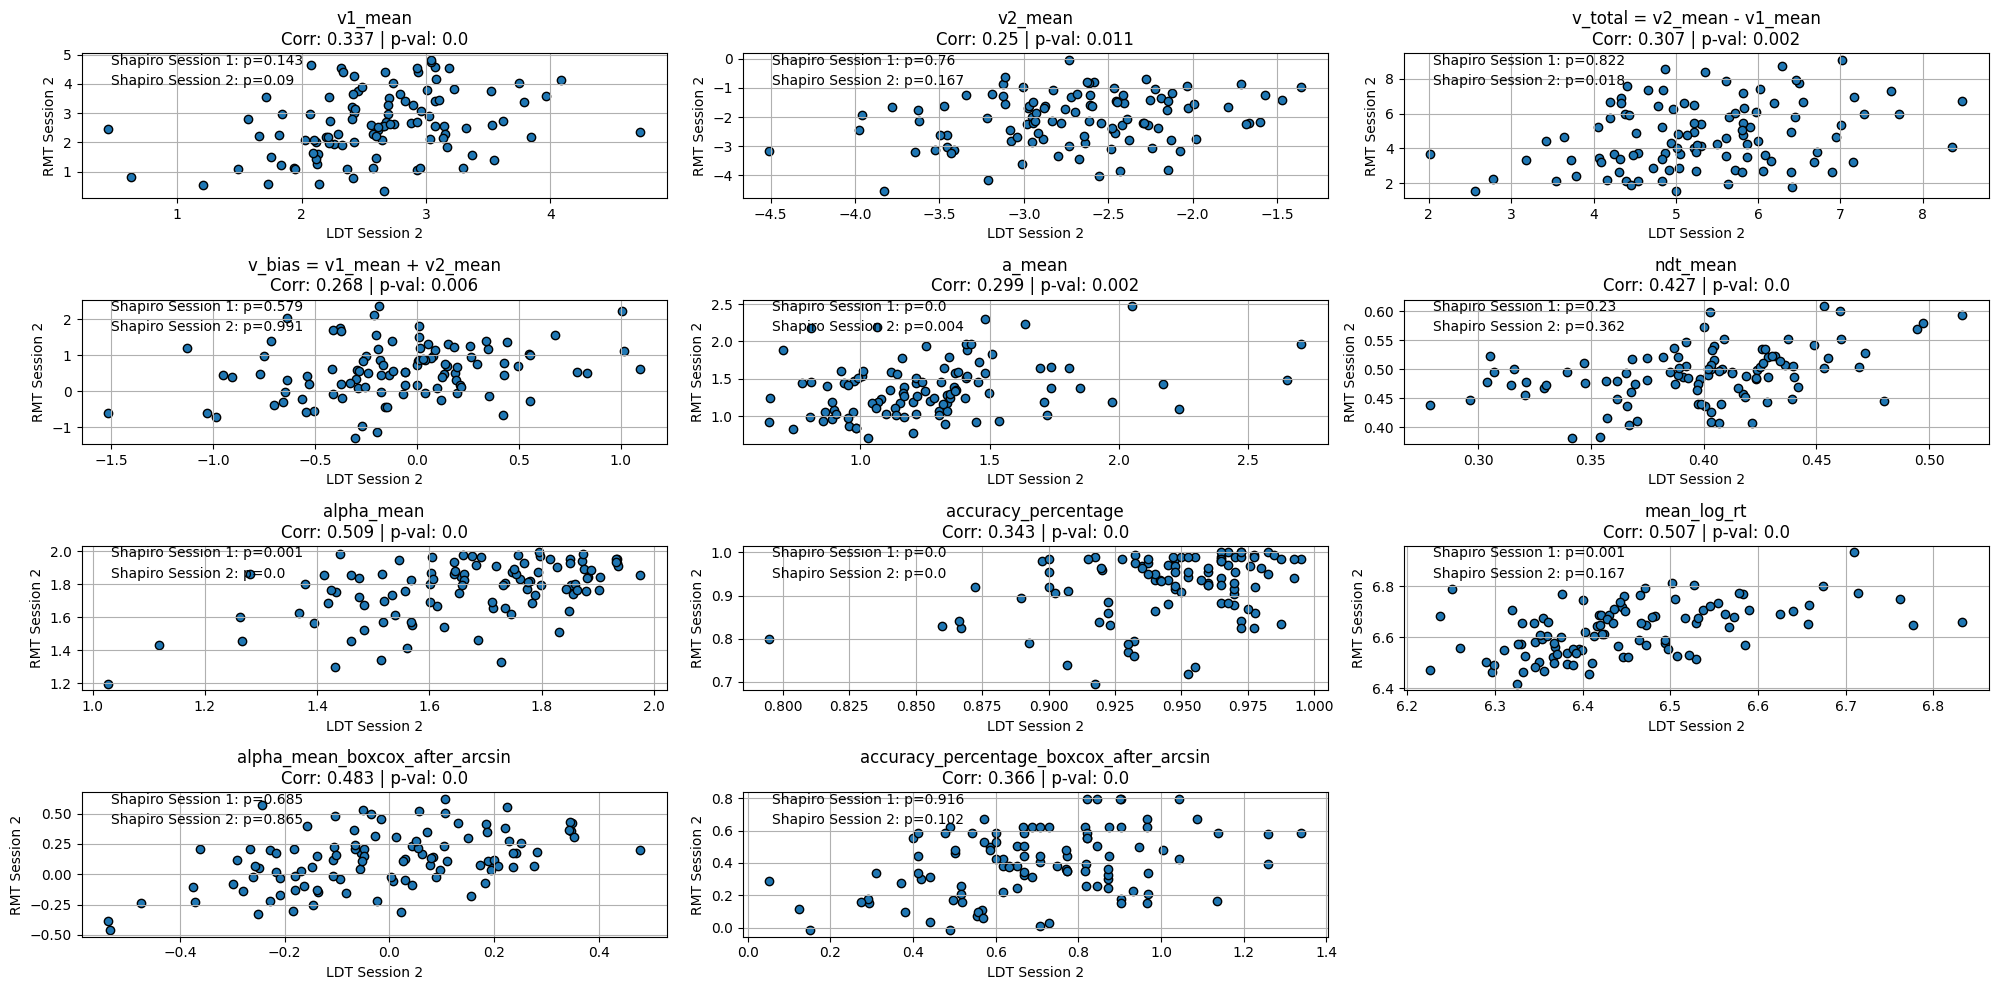

In [27]:

# Prepare the figure for subplots
num_vars = len(columns_for_analysis)
num_rows = int(np.ceil(np.sqrt(num_vars)))
num_cols = int(np.ceil(num_vars / num_rows))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust the size as needed
axes = axes.flatten()


Across_task_session_2_correlation_matrix = pd.DataFrame()

# Perform analysis for each variable and plot
for i, col in enumerate(columns_for_analysis):
    # Identify and remove outliers
    outlier_indices = identify_outliers([col], ldt_session_2_data, rmt_session_2_data)[col]
    clean_data = pd.concat([
        ldt_session_2_data.set_index('participant_ID')[col],
        rmt_session_2_data.set_index('participant_ID')[col]
    ], axis=1).drop(outlier_indices)
    
    # Calculate Pearson correlation
    correlation, p_value_corr = pearsonr(clean_data.iloc[:, 0], clean_data.iloc[:, 1])
    
    # Test for normality
    _, p_value_shapiro_1 = shapiro(clean_data.iloc[:, 0])
    _, p_value_shapiro_2 = shapiro(clean_data.iloc[:, 1])
    
    # Round the results to three decimals
    correlation = round(correlation, 3)
    Across_task_session_2_correlation_matrix.loc[col,'across_s2'] = correlation
    p_value_corr = round(p_value_corr, 3)
    p_value_shapiro_1 = round(p_value_shapiro_1, 3)
    p_value_shapiro_2 = round(p_value_shapiro_2, 3)
    
    # Plotting on the subplot
    ax = axes[i]
    ax.scatter(clean_data.iloc[:, 0], clean_data.iloc[:, 1], edgecolor='k')
    ax.set_title(f'{col}\nCorr: {correlation} | p-val: {p_value_corr}')
    ax.set_xlabel('LDT Session 2')
    ax.set_ylabel('RMT Session 2')
    ax.grid(True)
    
    # Annotate with Shapiro-Wilk test results
    ax.annotate(f'Shapiro Session 1: p={p_value_shapiro_1}', xy=(0.05, 0.92), xycoords='axes fraction')
    ax.annotate(f'Shapiro Session 2: p={p_value_shapiro_2}', xy=(0.05, 0.78), xycoords='axes fraction')

# Hide any unused subplots
for ax in axes[len(columns_for_analysis):]:
    ax.set_visible(False)

# Adjust layout for readability and save the figure
plt.tight_layout()
plt.savefig('EZ_Across_Task_Session_2_combined_correlation_plots.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [28]:
Across_task_session_2_correlation_matrix

,across_s2
v1_mean,0.337
v2_mean,0.250
v_total = v2_mean - v1_mean,0.307
v_bias = v1_mean + v2_mean,0.268
a_mean,0.299
ndt_mean,0.427
alpha_mean,0.509
accuracy_percentage,0.343
mean_log_rt,0.507
alpha_mean_boxcox_after_arcsin,0.483


# Across Task Session 1 Making data suitable 

In [29]:
ldt_session_1_data = new_ldt_session_1_data
rmt_session_1_data = rmt_session_1_data
ldt_session_1_data

,Experiment,v1_mean,v2_mean,v_total = v2_mean - v1_mean,v_bias = v1_mean + v2_mean,a_mean,ndt_mean,alpha_mean,accuracy_percentage,mean_log_rt,...,q1_E,q2_E,q3_E,q4_E,participant_ID,alpha_mean_shifted,alpha_mean_arcsin,alpha_mean_boxcox_after_arcsin,accuracy_percentage_arcsin,accuracy_percentage_boxcox_after_arcsin
0,001_class_words_part_1.dat,1.735638,-1.647395,3.383032,0.088243,1.196706,0.361422,1.458020,0.899749,6.522493,...,[0.41 0.467 0.491 0.41 0.523 0.521 0.409 0.5...,[0.626 0.617 0.602 0.547 0.562 0.539 0.538 0.5...,[0.755 0.667 0.858 0.642 0.641 0.682 0.818 0.7...,[0.89 0.954 0.914 0.914 1.017 0.875 1.235 0.8...,1,0.458020,0.743369,-0.225418,1.248628,0.478991
1,002_class_words_part_1.dat,1.646541,-2.039125,3.685666,-0.392584,1.171614,0.513238,1.927072,0.914573,6.651658,...,[0.762 0.619 0.682 0.594 0.77 0.634 0.738 0.5...,[0.794 0.803 0.794 0.842 0.834 0.802 0.858 0.834],[0.995 0.946 0.866 0.946 0.939 0.906 0.995 0.874],[1.035 1.281 1.027 1.122 2.306 1.026 1.018 1.1...,2,0.927072,1.297350,0.338815,1.274187,0.564924
2,003_class_words_part_1.dat,2.671191,-2.926153,5.597344,-0.254962,1.275182,0.435791,1.956327,0.977500,6.492267,...,[0.555 0.586 0.538],[0.594 0.593],[0.795 0.833],[1.347 2.026],3,0.956327,1.360264,0.421069,1.420228,1.264399
3,004_class_words_part_1.dat,2.367079,-2.302624,4.669703,0.064455,1.111747,0.384127,1.457351,0.930000,6.427847,...,[0.45 0.482 0.514 0.475 0.386 0.498 0.418],[0.522 0.523 0.53 0.522 0.578 0.522 0.578 0.529],[0.609 0.675 0.666 0.634 0.658 0.579],[0.795 0.682 0.866 1.138 0.914 0.794 0.97 ],4,0.457351,0.742697,-0.225926,1.303033,0.673343
4,005_class_words_part_1.dat,2.961030,-3.611128,6.572158,-0.650098,1.424967,0.406036,1.885865,0.985000,6.439964,...,[0.611 0.61 ],[0.642],[0.947],[1.073 1.098],5,0.885865,1.226176,0.250195,1.448014,1.446927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,4009_class_words_part_1.dat,2.250238,-1.725310,3.975548,0.524928,2.374114,0.319318,1.908496,0.984000,6.772617,...,[0.774 0.463],[0.902],[1.39],[2.318 2.314],4009,0.908496,1.263486,0.296063,1.443965,1.419175
100,4010_class_words_part_1.dat,3.328432,-3.054612,6.383044,0.273820,1.917051,0.273740,1.428962,0.930000,6.374000,...,[0.511 0.439 0.415 0.495 0.47 0.422 0.503],[0.55 0.55 0.519 0.534 0.542 0.542 0.529],[0.566 0.615 0.605 0.583 0.606 0.558 0.551],[0.814 0.823 1.19 0.75 0.79 0.694 0.75 ],4010,0.428962,0.714119,-0.247123,1.303033,0.673343
101,4011_class_words_part_1.dat,1.661596,-1.827556,3.489152,-0.165960,0.984396,0.339921,1.428092,0.864322,6.406905,...,[0.478 0.446 0.447 0.455 0.431 0.494 0.486 0.4...,[0.518 0.518 0.527 0.543 0.501 0.558 0.503 0.5...,[0.614 0.678 0.678 0.678 0.573 0.678 0.622 0.6...,[0.711 0.838 1.078 0.71 0.749 0.758 0.718 0.7...,4011,0.428092,0.713240,-0.247762,1.193568,0.322504
102,4012_class_words_part_1.dat,2.128155,-2.268161,4.396315,-0.140006,1.129517,0.374110,1.609163,0.942356,6.426793,...,[0.486 0.478 0.486 0.398 0.422 0.486],[0.558 0.591 0.559 0.557 0.525 0.585],[0.702 0.606 0.662 0.709 0.631],[0.966 1.11 0.718 0.734 1.141 0.91 ],4012,0.609163,0.895448,-0.099388,1.328336,0.779336


In [30]:
ldt_session_1_data=ldt_session_1_data.sort_values(by=['participant_ID'], ascending=False)
rmt_session_1_data=rmt_session_1_data.sort_values(by=['participant_ID'], ascending=False)
ldt_session_1_data=ldt_session_1_data[ldt_session_1_data['participant_ID'].isin(rmt_session_1_data['participant_ID'])]

In [31]:
new_outliers_dict = identify_outliers(columns_for_analysis, ldt_session_1_data, rmt_session_1_data)

# Display the number of outliers for each column
new_outlier_counts = {col: len(indices) for col, indices in new_outliers_dict.items()}
new_outlier_counts


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1,
 'v2_mean': 0,
 'v_total = v2_mean - v1_mean': 1,
 'v_bias = v1_mean + v2_mean': 0,
 'a_mean': 1,
 'ndt_mean': 0,
 'alpha_mean': 2,
 'accuracy_percentage': 1,
 'mean_log_rt': 1,
 'alpha_mean_boxcox_after_arcsin': 0,
 'accuracy_percentage_boxcox_after_arcsin': 0}

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

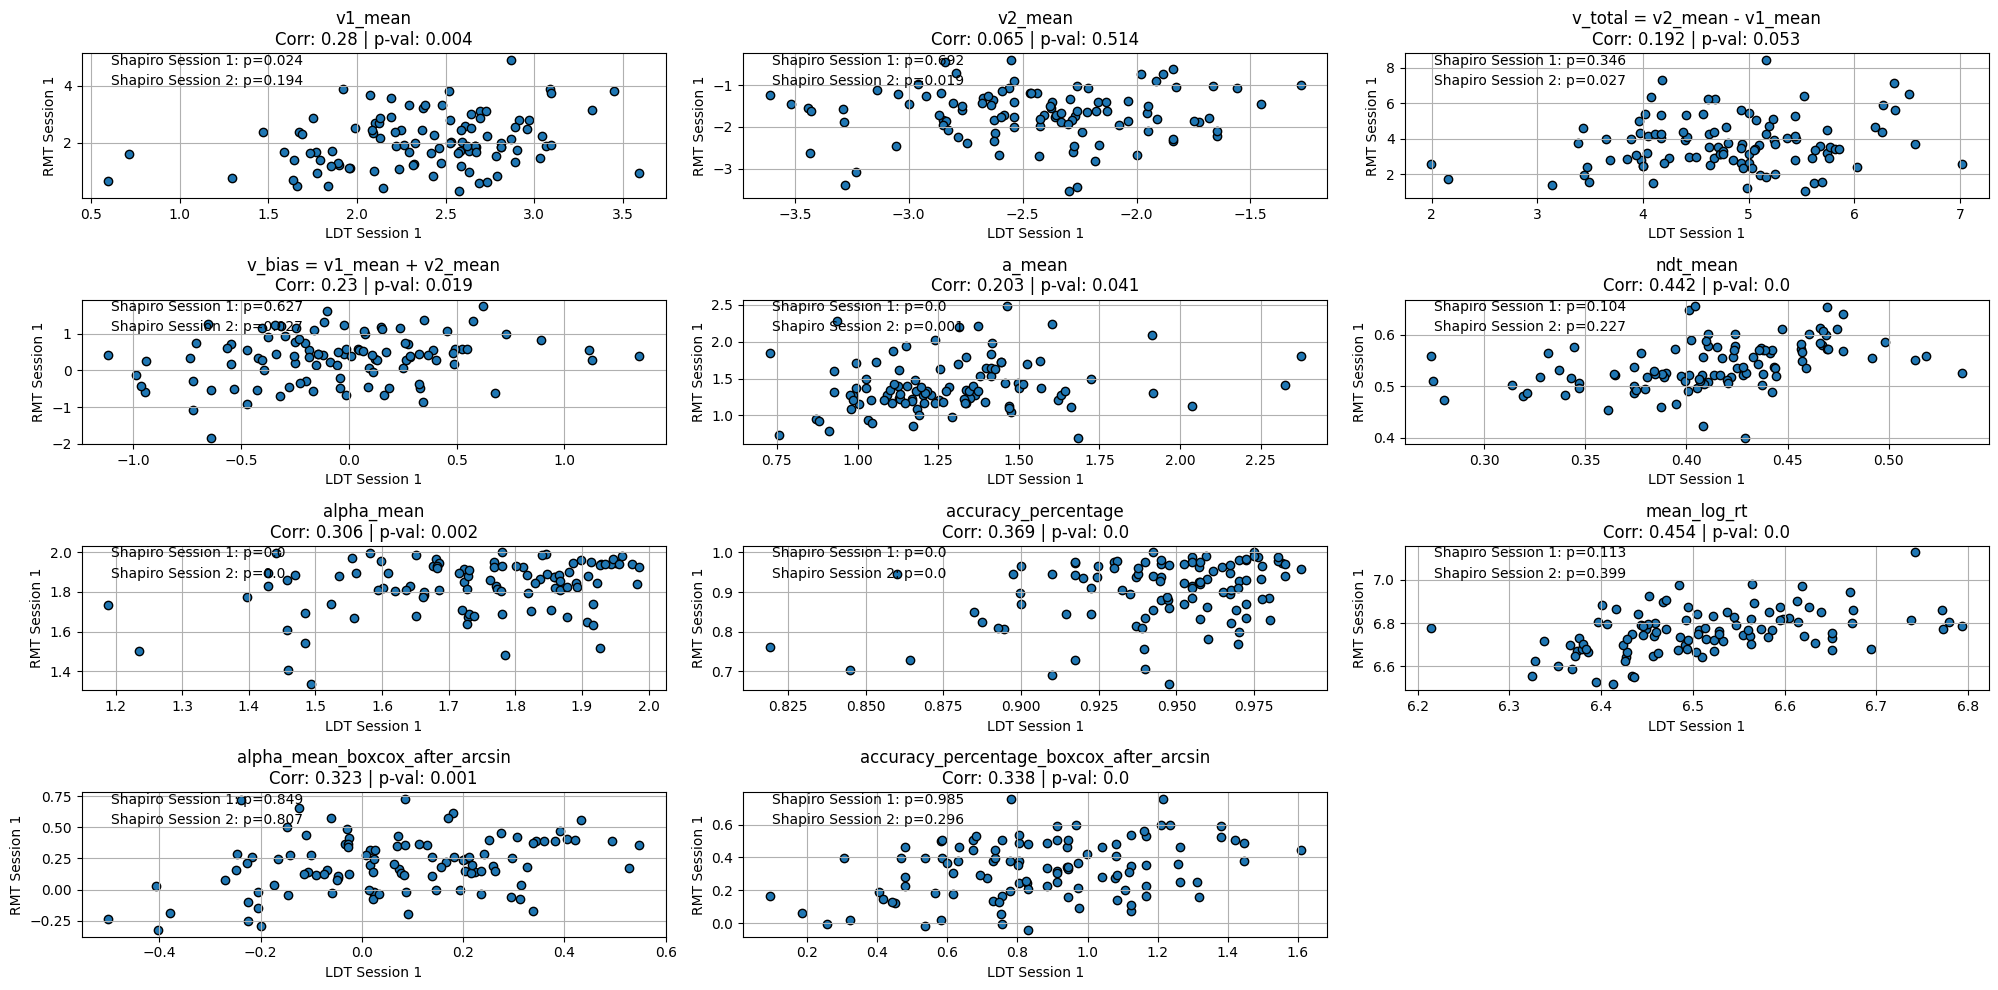

In [29]:

# Prepare the figure for subplots
num_vars = len(columns_for_analysis)
num_rows = int(np.ceil(np.sqrt(num_vars)))
num_cols = int(np.ceil(num_vars / num_rows))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust the size as needed
axes = axes.flatten()


Across_task_session_1_correlation_matrix = pd.DataFrame()
# Perform analysis for each variable and plot
for i, col in enumerate(columns_for_analysis):
    # Identify and remove outliers
    outlier_indices = identify_outliers([col], ldt_session_1_data, rmt_session_1_data)[col]
    clean_data = pd.concat([
        ldt_session_1_data.set_index('participant_ID')[col],
        rmt_session_1_data.set_index('participant_ID')[col]
    ], axis=1).drop(outlier_indices)
    
    # Calculate Pearson correlation
    correlation, p_value_corr = pearsonr(clean_data.iloc[:, 0], clean_data.iloc[:, 1])
    
    # Test for normality
    _, p_value_shapiro_1 = shapiro(clean_data.iloc[:, 0])
    _, p_value_shapiro_2 = shapiro(clean_data.iloc[:, 1])
    
    # Round the results to three decimals
    correlation = round(correlation, 3)
    p_value_corr = round(p_value_corr, 3)
    # Across_task_session_1_correlation_matrix.loc[col,'across_s2']=correlation
    Across_task_session_1_correlation_matrix.loc[col,'across_s1']=correlation

    p_value_shapiro_1 = round(p_value_shapiro_1, 3)
    p_value_shapiro_2 = round(p_value_shapiro_2, 3)
    
    # Plotting on the subplot
    ax = axes[i]
    ax.scatter(clean_data.iloc[:, 0], clean_data.iloc[:, 1], edgecolor='k')
    ax.set_title(f'{col}\nCorr: {correlation} | p-val: {p_value_corr}')
    ax.set_xlabel('LDT Session 1')
    ax.set_ylabel('RMT Session 1')
    ax.grid(True)
    
    # Annotate with Shapiro-Wilk test results
    ax.annotate(f'Shapiro Session 1: p={p_value_shapiro_1}', xy=(0.05, 0.92), xycoords='axes fraction')
    ax.annotate(f'Shapiro Session 2: p={p_value_shapiro_2}', xy=(0.05, 0.78), xycoords='axes fraction')

# Hide any unused subplots
for ax in axes[len(columns_for_analysis):]:
    ax.set_visible(False)

# Adjust layout for readability and save the figure
plt.tight_layout()
plt.savefig('EZ_Across_Task_Session_1_combined_correlation_plots.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [30]:
Across_task_session_1_correlation_matrix

,across_s1
v1_mean,0.280
v2_mean,0.065
v_total = v2_mean - v1_mean,0.192
v_bias = v1_mean + v2_mean,0.230
a_mean,0.203
ndt_mean,0.442
alpha_mean,0.306
accuracy_percentage,0.369
mean_log_rt,0.454
alpha_mean_boxcox_after_arcsin,0.323


In [31]:
reliability = [LDT_Bet_session_correlation_matrix,
               RMT_Bet_session_correlation_matrix,
    Across_task_session_1_correlation_matrix,
Across_task_session_2_correlation_matrix,

]

In [32]:
Across_task_session_1_correlation_matrix

,across_s1
v1_mean,0.280
v2_mean,0.065
v_total = v2_mean - v1_mean,0.192
v_bias = v1_mean + v2_mean,0.230
a_mean,0.203
ndt_mean,0.442
alpha_mean,0.306
accuracy_percentage,0.369
mean_log_rt,0.454
alpha_mean_boxcox_after_arcsin,0.323


In [33]:
reliabliity_datafram = pd.concat(reliability, axis=1, join='inner')


In [34]:
reliabliity_datafram.to_csv('EZ_study_1_bet&acros_reliabliity_datafram.csv',index=True)

In [35]:
pd.read_csv('EZ_study_1_bet&acros_reliabliity_datafram.csv')

,Unnamed: 0,LDT_Bet_session,RMT_Bet_session,across_s1,across_s2
0,v1_mean,0.777,0.757,0.280,0.337
1,v2_mean,0.797,0.659,0.065,0.250
2,v_total = v2_mean - v1_mean,0.805,0.748,0.192,0.307
3,v_bias = v1_mean + v2_mean,0.717,0.576,0.230,0.268
4,a_mean,0.578,0.600,0.203,0.299
5,ndt_mean,0.511,0.497,0.442,0.427
6,alpha_mean,0.725,0.448,0.306,0.509
7,accuracy_percentage,0.885,0.801,0.369,0.343
8,mean_log_rt,0.758,0.697,0.454,0.507
9,alpha_mean_boxcox_after_arcsin,0.696,0.485,0.323,0.483
